In [2]:
%matplotlib inline

# Laden der verwendeten Bibliotheken
import   numpy  as np   
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import   cv2

In [3]:
def imshow(img):
    shape=img.shape
    plt.figure(figsize = (10,10))
    if(len(shape)==2):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis(False)
    plt.show()   

In [4]:
def fullContrast(img):
    min=np.min(img)
    max=np.max(img)
    return (img-min).astype(float)/(max-min)

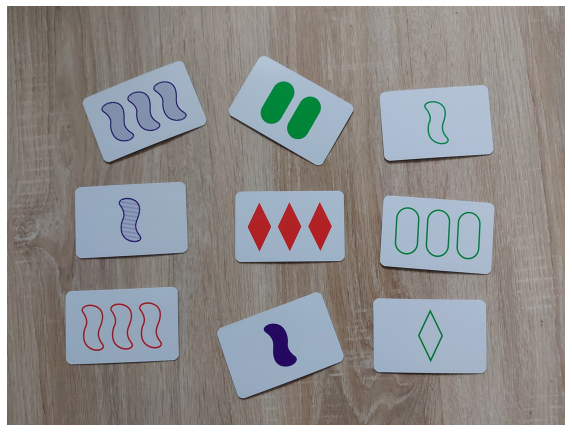

In [5]:
# Bild laden mit OpenCV
img = cv2.imread("set/set1.jpg")
imshow(img)

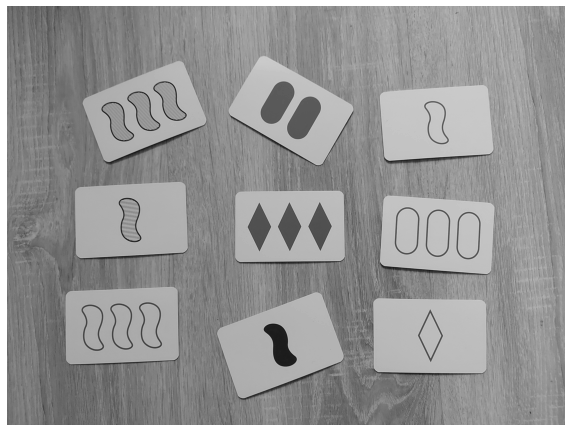

In [6]:
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

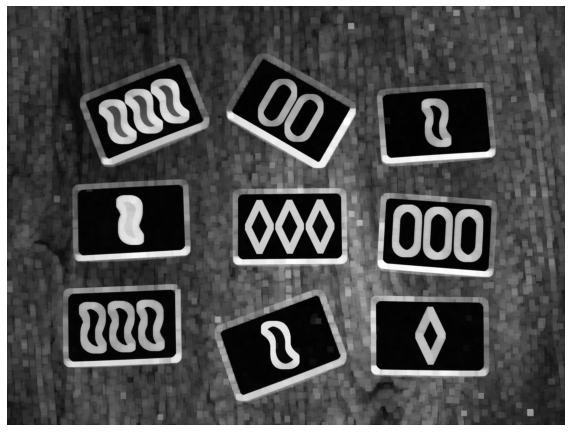

In [7]:
morphgradient=cv2.dilate(gray,np.ones((23,23)))-cv2.erode(gray,np.ones((23,23)))
imshow(morphgradient)

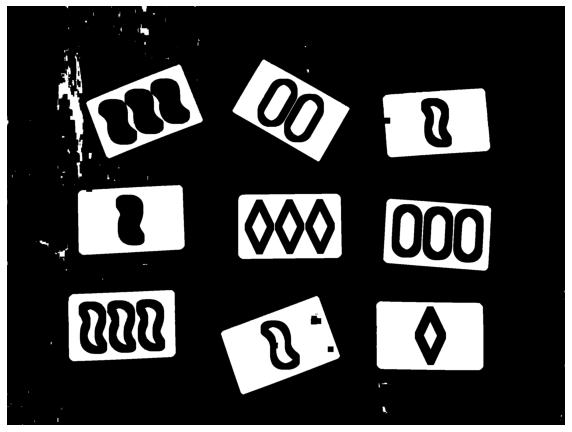

In [8]:
regions=(morphgradient<20).astype(np.uint8)
imshow(fullContrast(regions))

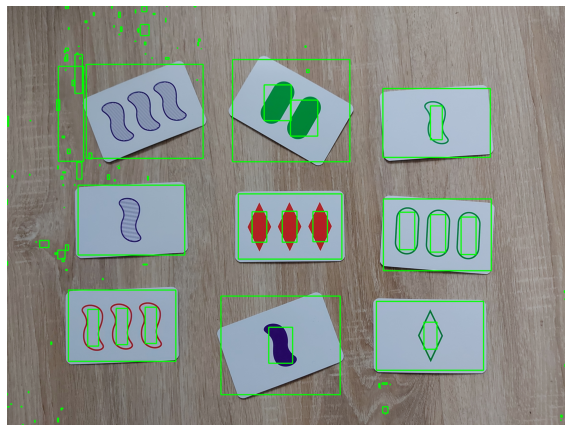

In [9]:
(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(regions, 4, cv2.CV_32S)
boundingboxview=img.copy()
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(boundingboxview,(x,y),(x+w,y+h),(0,255,0),3)
    mask=(labels==i).astype(np.uint8)
imshow(boundingboxview)

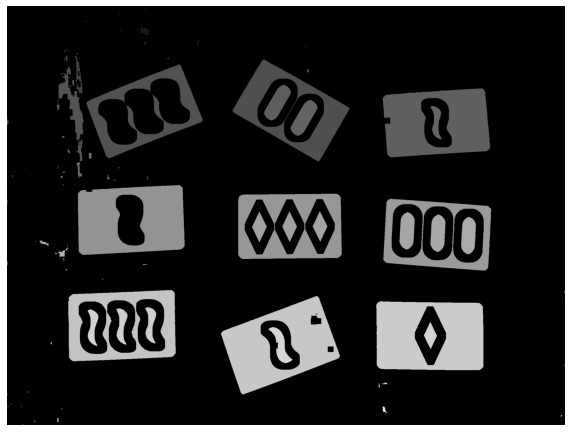

In [10]:
imshow(labels)

In [11]:
# Extrahieren aller äußeren Konturen als Liste von Pixelketten
contours,_ = cv2.findContours(regions,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))

109


In [12]:
contour=contours[62]
print(contour.shape)
print(contour)

(85, 1, 2)
[[[  0 456]]

 [[  0 457]]

 [[  0 458]]

 [[  0 459]]

 [[  0 460]]

 [[  0 461]]

 [[  0 462]]

 [[  0 463]]

 [[  0 464]]

 [[  0 465]]

 [[  0 466]]

 [[  0 467]]

 [[  0 468]]

 [[  0 469]]

 [[  0 470]]

 [[  0 471]]

 [[  0 472]]

 [[  0 473]]

 [[  0 474]]

 [[  0 475]]

 [[  0 476]]

 [[  0 477]]

 [[  0 478]]

 [[  0 479]]

 [[  0 480]]

 [[  0 481]]

 [[  0 482]]

 [[  0 483]]

 [[  0 484]]

 [[  0 485]]

 [[  0 486]]

 [[  0 487]]

 [[  0 488]]

 [[  0 489]]

 [[  0 490]]

 [[  0 491]]

 [[  0 492]]

 [[  0 493]]

 [[  0 494]]

 [[  0 495]]

 [[  0 496]]

 [[  0 495]]

 [[  0 494]]

 [[  0 493]]

 [[  0 492]]

 [[  0 491]]

 [[  1 490]]

 [[  1 489]]

 [[  1 488]]

 [[  1 487]]

 [[  2 486]]

 [[  3 486]]

 [[  4 486]]

 [[  4 485]]

 [[  4 484]]

 [[  5 483]]

 [[  5 482]]

 [[  5 481]]

 [[  5 480]]

 [[  5 479]]

 [[  5 478]]

 [[  5 477]]

 [[  5 476]]

 [[  5 475]]

 [[  5 474]]

 [[  4 474]]

 [[  3 474]]

 [[  2 474]]

 [[  1 473]]

 [[  1 472]]

 [[  0 47

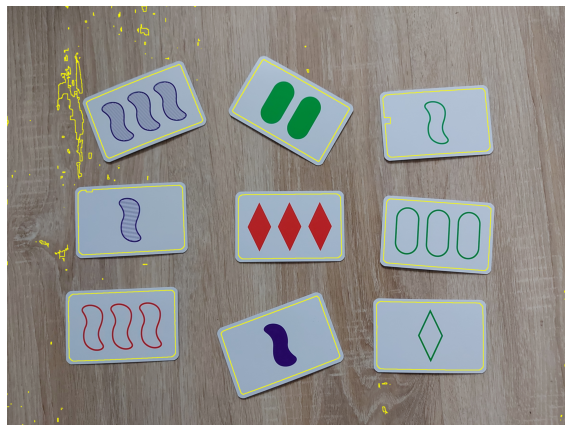

In [13]:
annotated=img.copy()

for contour in contours: 
    cv2.drawContours(annotated, [contour], 0, (0,255,255), 2)
    
imshow(annotated)

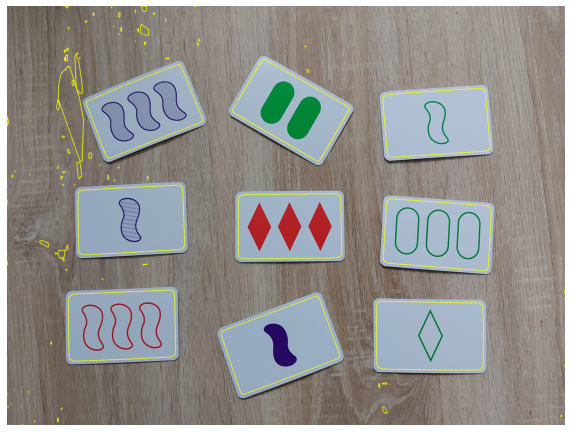

In [14]:
annotated=img.copy()

for contour in contours:
    
    convex=cv2.convexHull(contour) 

    cv2.drawContours(annotated, [convex], 0, (0,255,255), 2)

imshow(annotated)

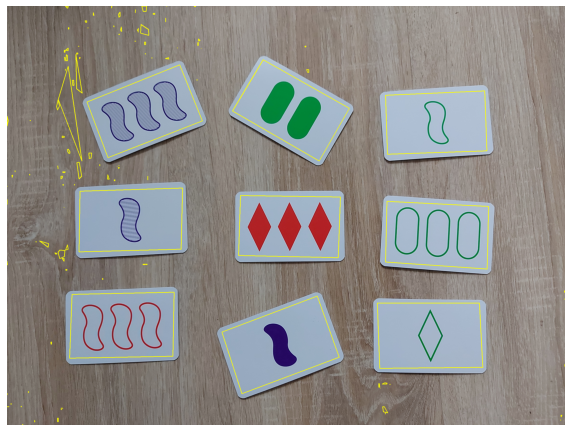

In [15]:
annotated=img.copy()

for contour in contours:
    convex=cv2.convexHull(contour) 

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    cv2.drawContours(annotated, [approx], 0, (0,255,255), 2)
imshow(annotated)

In [16]:
# Liste zum Speichern der Rechtecke zu den gefundenen Karten
card_quadrangles=[]


for contour in contours:

    convex=cv2.convexHull(contour) # Konvexe Hülle bilden

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    if(len(approx)!=4): # Viereckstest
        continue
        
    # Alle vier Kantenlängen ermitteln. "cv2.norm" berechnet per Default die L2-Norm, also den Euklidischen Abstand
    l0=cv2.norm(approx[0],approx[1]) 
    l1=cv2.norm(approx[1],approx[2])
    l2=cv2.norm(approx[2],approx[3])
    l3=cv2.norm(approx[3],approx[0])
    
    # Mittlere Breite und Höhe bestimmen (Annahme: Parallelogramm)
    w,h = (l0+l2)/2, (l1+l3)/2
    
    if(abs(l0-l2)>0.15*w) | (abs(l1-l3)>0.15*h): # Parallelogrammtest
        continue
    
    # Wenn Breite>Höhe: um 90° drehen (eine Karte ist höher als breit)
    if(w>h):
        w,h = h,w
        approx=np.roll(approx,1,axis=0)

    if(w  <100) | (h > 600): # Größentest
        continue

    if(h > 2.2*w) | (h<1.2 * w):   # Seitenverhältnistest
        continue

    card_quadrangles.append(np.squeeze(approx))

print(len(card_quadrangles))

9


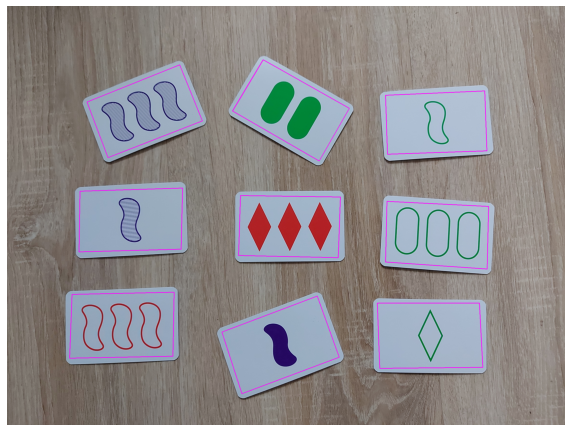

In [17]:
annotated=img.copy()
for quad in card_quadrangles:
    cv2.drawContours(annotated, [quad], 0, (255,0,255), 2)
imshow(annotated)

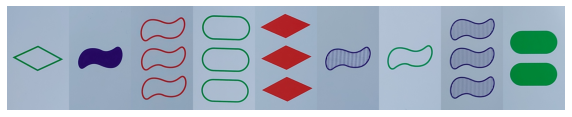

In [18]:
result = None

cards = []

for card in card_quadrangles:
    
    destRect = np.float32([[0,0],[300,0],[300,500],[0,500]])

    transformMatrix = cv2.getPerspectiveTransform(card.astype(np.float32), destRect)

    cardImage = cv2.warpPerspective(img,transformMatrix,(300,500))
    
    cards.append(cardImage)
    
    if result is None:
        result=cardImage.copy()
    else:
        result=np.concatenate([result,cardImage],axis=1)   

imshow(result)

In [19]:
#Anzahl
for card in cards:
    # Convert to grayscale
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

    # Apply Otsu thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,2)

    # imshow(255 - thresh)
    
    objectCount = 0
    # Find contours
    contours, hierachy = cv2.findContours(255 - thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 13000:
            objectCount += 1
    
    print(objectCount)    


1
1
3
3
3
1
1
3
2


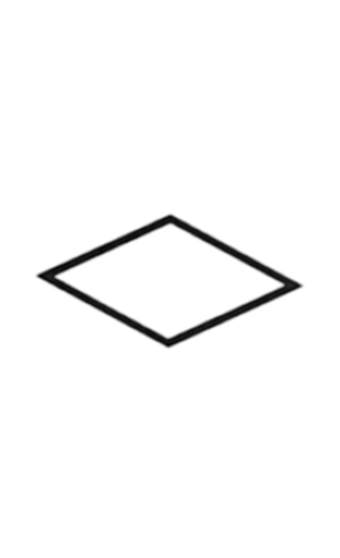

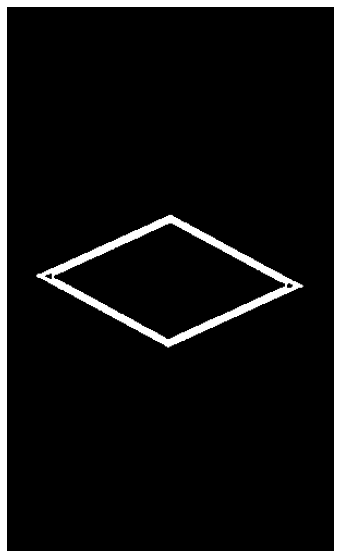

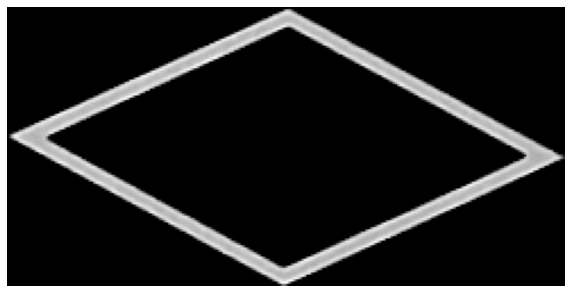

10.294467578822129
empty


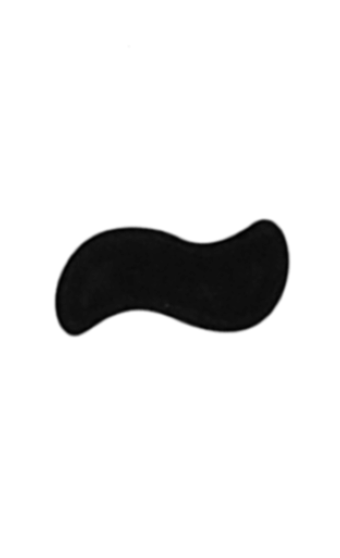

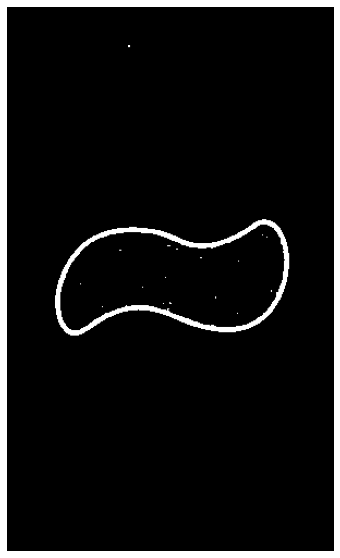

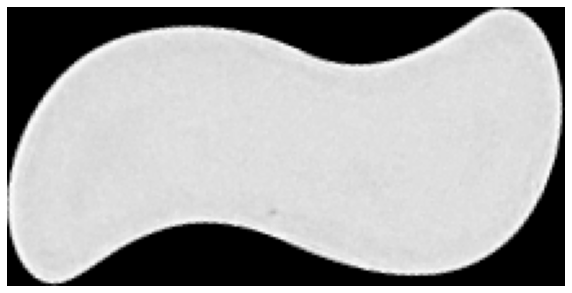

91.8196159122085
filled


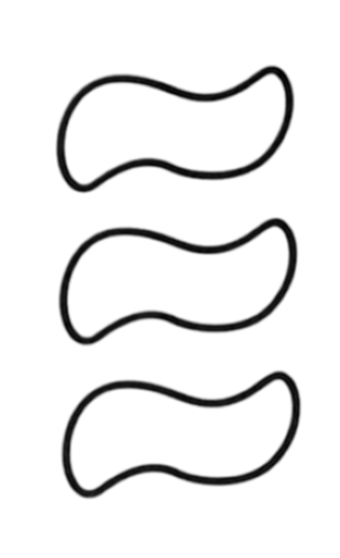

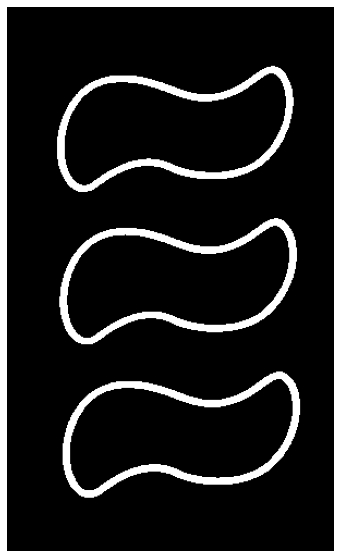

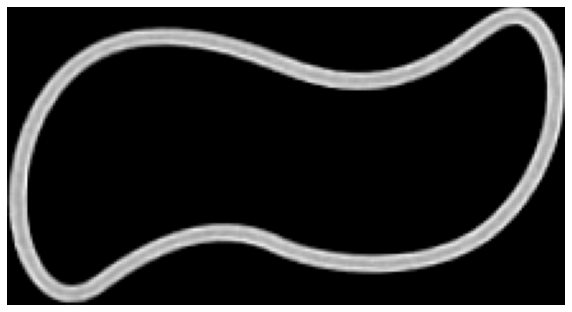

14.501541583733365
empty


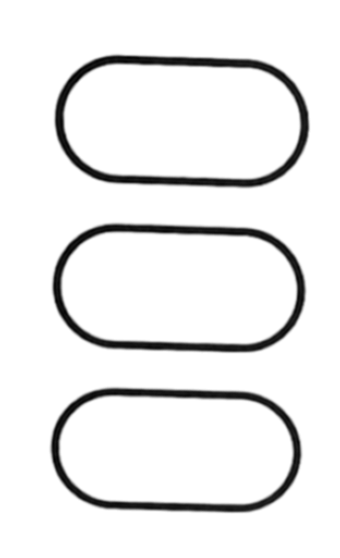

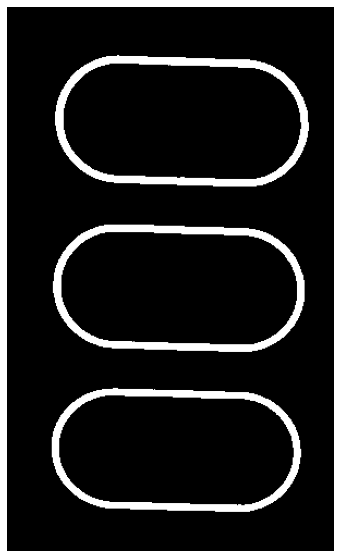

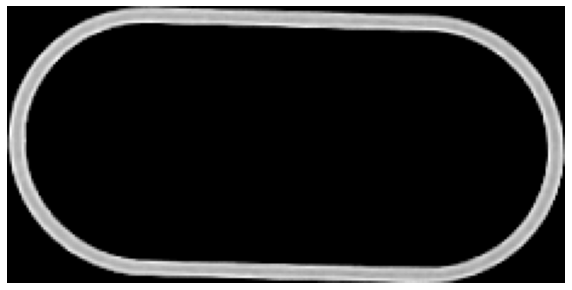

11.693554538520214
empty


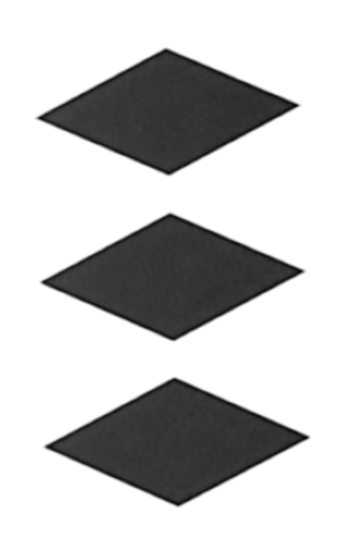

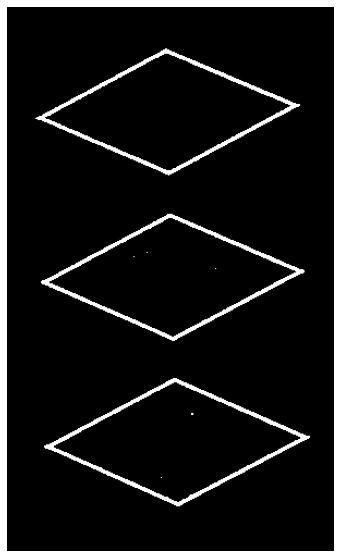

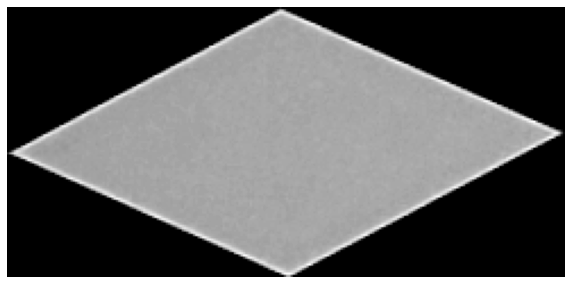

39.63329234132677
filled


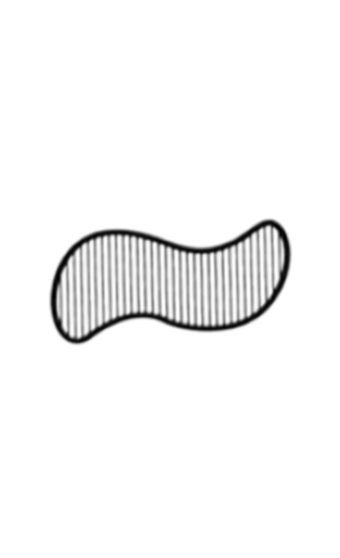

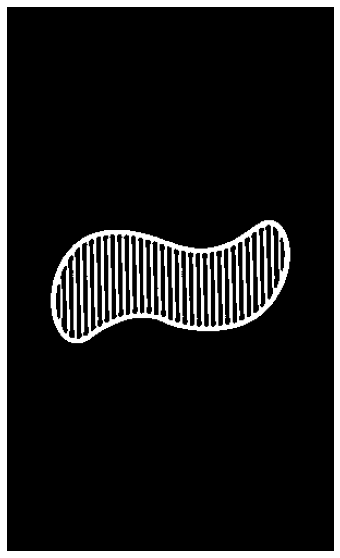

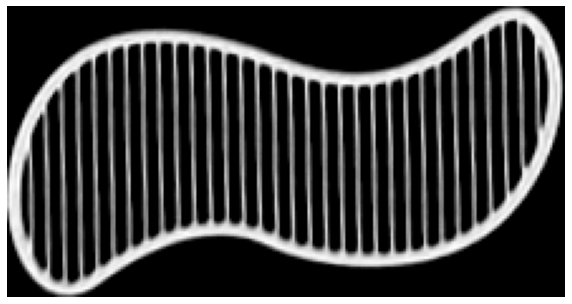

30.147039150108203
striped


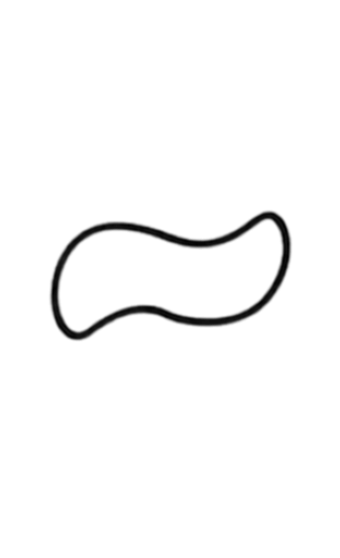

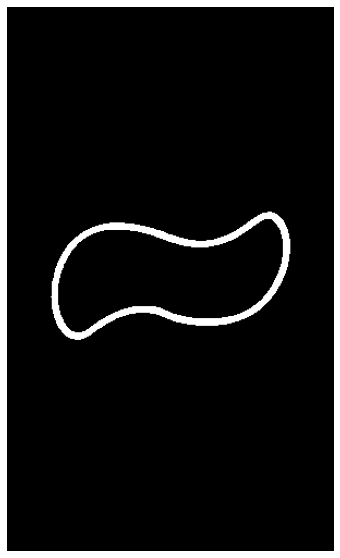

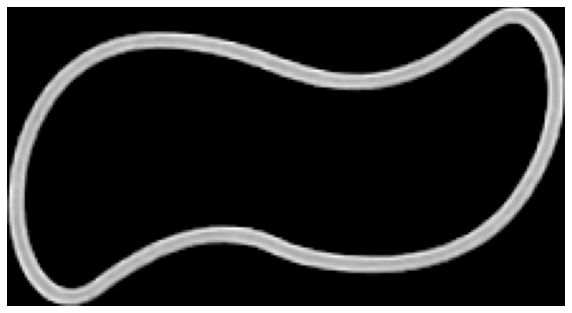

10.609707241910632
empty


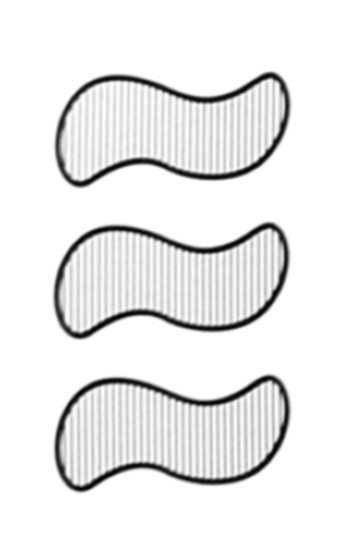

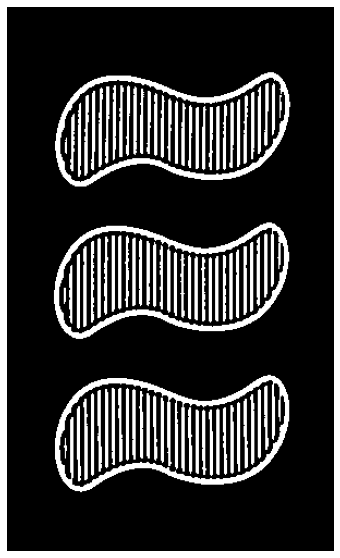

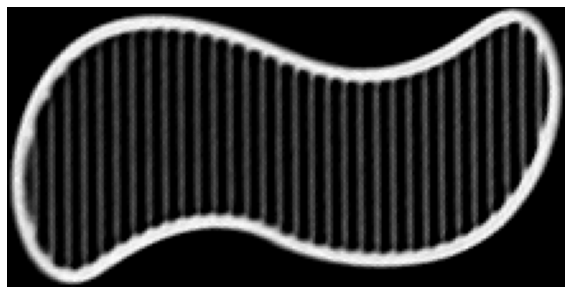

25.577874636778745
striped


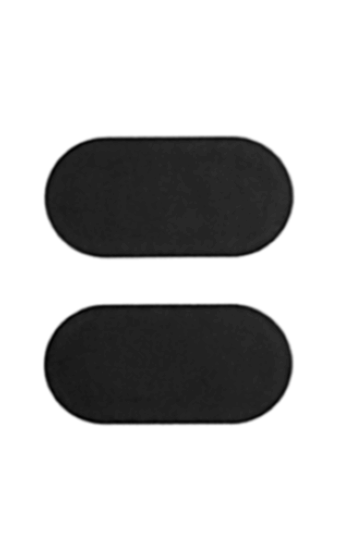

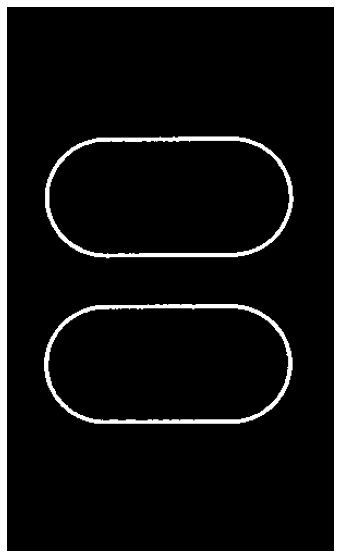

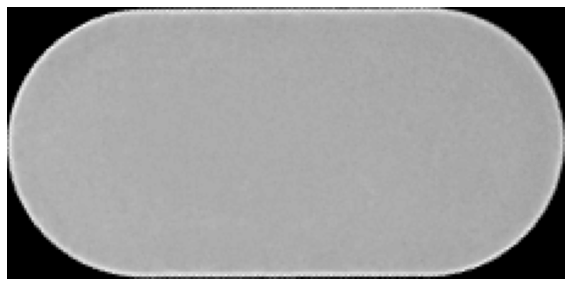

62.73609135451241
filled


In [36]:
#TODO still not working because thresholding doesnt work properly
#TODO first use adaptive threshold to filter out striped, then filter filled/empty with Otsu
for card in cards:
    # Convert to grayscale
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
    gray = cv2.add(gray, 100)
    
    # Apply Otsu thresholding
    blur = cv2.GaussianBlur(gray,(5,5),0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    #ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    imshow(255-thresh)
    
    # Find contours
    contours, hierachy = cv2.findContours(255-gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 12000:
            # Get bounding rectangle of contour
            x, y, w, h = cv2.boundingRect(contour)
            
            # Extract ROI from original image
            #roi = 255 - thresh[int(y+h/2-30):int(y+h/2+30), int(x+w/2-30):int(x+w/2+30)]
            roi = 255 - gray[y:y+h,x:x+w]
            meanVal = np.mean(roi)

            imshow(roi)
            print(meanVal)
            if meanVal > 38:
                print("filled")
            elif meanVal < 15:
                print("empty")
            else:
                print("striped")

            break
        
